<a href="https://colab.research.google.com/github/gitmayanksingh/Building-a-CHATBOT/blob/master/Chatbot-RIKI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


```
# OPEN IN GOOGLE COLAB FOR BETTER EXPERIENCE. 
```



# Building a Chatbot from Scratch 

---



##### In this project we will build a chatbot from scratch using the corenell University's Movie Dialogue corpus.
##### We will be using a deep learning based architecture with the main components as a lstm based encoder and decoder.

In [0]:
!pip install textBlob

In [0]:
!pip install pyspellchecker

     |████████████████████████████████| 1.9MB 6.2MB/s 


In [0]:
from keras.models import Model
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Input, Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from collections import Counter
import nltk
import numpy as np
from sklearn.model_selection import train_test_split
from textblob import TextBlob
import re
from spellchecker import SpellChecker

In [0]:
import keras
import nltk
import numpy
import sklearn

* Please make sure that the version of the respective packages are met to the requirement

In [0]:
keras_v = keras.__version__
ntlt_v = nltk.__version__
sklearn_v = sklearn.__version__
numpy_v = numpy.__version__

In [0]:
assert keras.__version__==keras_v
assert nltk.__version__==ntlt_v
assert sklearn.__version__==sklearn_v
assert numpy.__version__==numpy_v

Download the glove model available at https://nlp.stanford.edu/projects/glove/

Specification : Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB download): glove.twitter.27B.zip


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Hyperparameter tuning 
RAND_STATE=np.random.seed(42)
BATCH_SIZE = 32
NUM_EPOCHS = 10
GLOVE_EMBEDDING_SIZE = 100
HIDDEN_UNITS = 256
MAX_INPUT_SEQ_LENGTH = 40
MAX_TARGET_SEQ_LENGTH = 40
MAX_VOCAB_SIZE = 10000
DATA_SET_NAME = '/content/drive/My Drive/data'
DATA_PATH = DATA_SET_NAME+'/Industry Grade Project - Building a Chatbot/movie_lines_cleaned.txt'
WEIGHT_FILE_PATH = DATA_SET_NAME+'/Industry Grade Project - Building a Chatbot/model-weights.h5'
GLOVE_MODEL = DATA_SET_NAME+"/glove.twitter.27B/glove.twitter.27B." + str(GLOVE_EMBEDDING_SIZE) + "d.txt"
WHITELIST = 'abcdefghijklmnopqrstuvwxyz1234567890?.,'
ignore_words = ['?', '!']

* Function **in_white_list()** checks whether the words in **movie_lines_cleaned.txt** formed with Valid characters.

In [0]:
#defines the valid characters for the chatbot
def in_white_list(_word):
    for char in _word:
        if char in WHITELIST:
            return True

    return False

* Load the glove word embedding in to a dictionary where the **key** is a unique **word token** and the **value** is a **d** dimension vector 

# Test-1

In [0]:
def load_glove_vector():
    _word2embedding = {}
    file = open(GLOVE_MODEL, mode='rt', encoding='utf8')
    for line in file:
        words = line.strip().split()
        #print(words)
        word = words[0]
        embeds = np.array(words[1:], dtype=np.float32)
        _word2embedding[word] = embeds
        
    file.close()
    print('Glove Loaded !')
    file.close()
    return _word2embedding

In [0]:
%%time
word2embedding = load_glove_vector()

Glove Loaded !
CPU times: user 37 s, sys: 1.21 s, total: 38.2 s
Wall time: 41.4 s


*   Vector Representation for word : **robot**



In [0]:
word2embedding.get("robot")

array([ 3.6183e-01,  8.5236e-02, -3.8136e-01,  4.2704e-01, -1.0511e-01,
        3.9581e-01,  4.8758e-01, -8.8883e-01,  7.4575e-01, -2.5732e-02,
        2.1829e-01,  5.0398e-01, -1.7856e+00, -3.4789e-03,  1.6188e-01,
        1.0721e-01,  2.1314e-01, -5.4756e-02,  2.6118e-01, -3.8565e-01,
       -6.9957e-01,  1.4678e-01, -5.8236e-01, -3.5354e-01,  2.3200e-01,
       -7.7804e-01, -2.4003e-01,  2.5253e-01, -2.6848e-01, -1.2147e-01,
        3.8065e-01, -9.9212e-01,  2.4743e-01, -4.0389e-01,  6.0282e-01,
        9.8607e-02,  9.1581e-01,  1.9072e-01,  3.5004e-01, -3.1568e-01,
        5.8921e-02,  1.0758e-01, -7.2627e-01,  1.1434e-01,  8.2518e-01,
        8.2510e-01, -2.5450e-01,  4.6362e-01,  3.2809e-01, -4.2744e-01,
        4.2987e-01,  7.8949e-01, -1.2018e-01, -2.3686e-01,  3.6827e-03,
        5.5287e-02,  1.3540e-01,  7.5065e-02,  9.1749e-04,  1.9317e-01,
       -7.3923e-02, -2.7294e-02,  3.4125e-01, -3.7098e-01, -1.7008e-01,
       -1.8138e-01, -4.8424e-01,  3.3101e-01,  5.8830e-01, -8.83

In [0]:
del word2embedding['-0.32053'] 

In [0]:
len(word2embedding.get('robot'))

100

In [0]:
len(word2embedding.keys())

1193513

**NOTE :** Length of any word will always be 100 beacause the EMBEDDING SIZE is 100 for the GLOVE MODEL

# Check-1

In [0]:
assert len(word2embedding.keys())==1193513
for key in word2embedding.keys():
    try:
        assert len(word2embedding[key])==100
    except AssertionError:
        print (key,len(word2embedding[key])) 

print('Test Case 1 Passes!')    

Test Case 1 Passes!


# Data Preparation

In [0]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

* **punkt** is designed to learn parameter such as Abbrebiation , periods etc in the sentence

**For eg :** Punkt knows that the periods in Mr. Mayank and A.P.J Abdul Kalam do not mark sentence boundaries .

In [0]:
target_counter = Counter()
lines = open(DATA_PATH, 'rt', encoding='utf8').read().split('\n')
input_texts = []
target_texts = []
prev_words = []

## **Basic Text Preprocessing** <br>
This basic pre-processing is necessary because if the GLOVE Model did'nt understand the word ,then it will not create the Embedding for the word.

1.   Replace Contractions
2.   whitelist_lines()
3.   Spelling Correction Library
     *   TextBlob
     *   pyspellchecker





## 1. Replace Contractions

In [0]:
contraction_dict = {
  "aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not","couldn't've": "could not have",
  "didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not","haven't": "have not","he'd": "he would",
  "he'd've": "he would have","he'll": "he will","he'll've": "he will have","he's": "he is","how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how is","I'd": "I would",
  "I'd've": "I would have","I'll": "I will","I'll've": "I will have","I'm": "I am","I've": "I have","isn't": "is not","it'd": "it had",
  "it'd've": "it would have","it'll": "it will","it'll've": "it will have","it's": "it is","let's": "let us","ma'am": "madam",
  "mayn't": "may not","might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have","needn't": "need not",
  "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
  "shan't've": "shall not have","she'd": "she would","she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is","should've": "should have",
  "shouldn't": "should not","shouldn't've": "should not have","so've": "so have","so's": "so is",
  "that'd": "that would","that'd've": "that would have","that's": "that is","there'd": "there had","there'd've": "there would have","there's": "there is","they'd": "they would","they'd've": "they would have",
  "they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have","to've": "to have",
  "wasn't": "was not","we'd": "we had","we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have",
  "weren't": "were not","what'll": "what will","what'll've": "what will have","what're": "what are",
  "what's": "what is","what've": "what have","when's": "when is","when've": "when have","where'd": "where did","where's": "where is","where've": "where have","who'll": "who will",
  "who'll've": "who will have","who's": "who is","who've": "who have","why's": "why is","why've": "why have",
  "will've": "will have","won't": "will not","won't've": "will not have","would've": "would have",
  "wouldn't": "would not","wouldn't've": "would not have","y'all": "you all","y'alls": "you alls","y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
  "you'd": "you had","you'd've": "you would have","you'll": "you you will","you'll've": "you you will have","you're": "you are","you've": "you have"
  }

In [0]:
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

lines = [replace_contractions(line) for line in lines]

##  2. **whitelist_lines** function tries to remove :
1.   Removed **HTML Tags**
2.   Remove **-** and replace with ' ' (**space**)
3.   **Allowed Chacters** **->** a-z A-Z ! space ,? .
4.   **Repeating Punctuations** (?.!)[*Ex - Hi !!! to Hi !*]
5.   **Repeating Characters in the word** [*Ex - wayyy to way*]
6.   **Repeating Characters in between the words**
7.   **Period (.) before word and after word** [*Ex - .lion to lion*]
8.   **Double space,newline,tab to single space**

In [0]:
def whitelist_lines(line):
  line = re.sub('(<.*?>)','',line)
  line = re.sub(r'-+',r' ',line)
  line = re.sub(r'[^(a-zA-Z!\s,?\.)]*',r'',line)
  line = re.sub(r'([!?.,]){1,}\1',r'\1',line)
  line = re.sub(r'\b(\S*?)(.)\2{2,}\b',r'\1\2',line)
  line = re.sub(r'\b(\S*?)(.)\2{2,}(\S+)\b',r'\1\2\2\3',line)
  line = re.sub(r'([.])',r' . ',line)
  line = re.sub(r'\s+',r' ',line)
  return line.strip()

In [0]:
lines = [whitelist_lines(line) for line in lines]

In [0]:
lines[:10]

['They do not!',
 'They do to!',
 'I hope so .',
 'She okay?',
 'Lets go .',
 'Wow',
 'Okay you are gonna need to learn how to lie .',
 'No',
 'I am kidding . You know how sometimes you just become this persona? And you do not know how to quit?',
 'Like my fear of wearing pastels?']

## 3. Spelling Correction Library

These libraries are used to correct the Incorrect spellings in the text file.It supports multiple languages.

*   **TextBlob** - TextBlob.correct() function
*   **Spellchecker** - spellcheck.correction() function



**spelling_correction_textBlob** functions tries to correct the mis-spelled word in the lines.

In [0]:
def spelling_correction_textBlob(text):
  text = TextBlob(text).correct()
  return str(text)

* We are adding **start** and **end** to every target text.This will later help our **MODEL** to determine **when to start** and more importantly - **end sequences** . We need this due to the fact that we dont know a-priori how long the output sequence will be.

In [0]:
for line in lines:
    next_words = [w.lower() for w in nltk.word_tokenize(line)]
    if len(next_words) > MAX_TARGET_SEQ_LENGTH:
        next_words = next_words[0:MAX_TARGET_SEQ_LENGTH]
    if len(prev_words) > 0:
        input_texts.append(prev_words)
        target_words = next_words[:]
        target_words.insert(0, 'start')
        target_words.append('end')
        for w in target_words:
            target_counter[w] += 1
        target_texts.append(target_words)
    prev_words = next_words

In [0]:
print('Length of Input texts :',len(input_texts))
print('Length of Target texts :',len(target_texts))

Length of Input texts : 304443
Length of Target texts : 304443


Filter the conversations till max word length and convert the dialogues pairs into input text and target texts. Put **start** and **end** token to recognise the beginning and end of the sentence token.

## Let's see some of the training examples

In [0]:
for idx, (input_words, target_words) in enumerate(zip(input_texts, target_texts)):
    if idx > 10:
        break
    print([input_words, target_words])

[['they', 'do', 'not', '!'], ['start', 'they', 'do', 'to', '!', 'end']]
[['they', 'do', 'to', '!'], ['start', 'i', 'hope', 'so', '.', 'end']]
[['i', 'hope', 'so', '.'], ['start', 'she', 'okay', '?', 'end']]
[['she', 'okay', '?'], ['start', 'lets', 'go', '.', 'end']]
[['lets', 'go', '.'], ['start', 'wow', 'end']]
[['wow'], ['start', 'okay', 'you', 'are', 'gon', 'na', 'need', 'to', 'learn', 'how', 'to', 'lie', '.', 'end']]
[['okay', 'you', 'are', 'gon', 'na', 'need', 'to', 'learn', 'how', 'to', 'lie', '.'], ['start', 'no', 'end']]
[['no'], ['start', 'i', 'am', 'kidding', '.', 'you', 'know', 'how', 'sometimes', 'you', 'just', 'become', 'this', 'persona', '?', 'and', 'you', 'do', 'not', 'know', 'how', 'to', 'quit', '?', 'end']]
[['i', 'am', 'kidding', '.', 'you', 'know', 'how', 'sometimes', 'you', 'just', 'become', 'this', 'persona', '?', 'and', 'you', 'do', 'not', 'know', 'how', 'to', 'quit', '?'], ['start', 'like', 'my', 'fear', 'of', 'wearing', 'pastels', '?', 'end']]
[['like', 'my', 'f

### Create two dictionaries 
<ol>
<li>target_word2id
<li>target_id2word
</ol>
and save it as NumPy file format in the disk.
<p>
<strong>NOTE:</strong> The ids should start from 1 beacause <strong>0</strong> is reserved for <strong>'unknown'</strong> tokens.
Make sure you cosider only the <strong>most common</strong> tokens with <strong>MAX_VOCAB_SIZE</strong> defined above.

Most common refers to tokens with higher frequency. 
</p>
<strong>Help:</strong>
<ol>
<li>Use the target_counter which have the token counts.  
<li>Use target_counter.most_common(MAX_VOCAB_SIZE) to filter common tokens
    </ol>

In [0]:
target_word2idx = dict()
'''create a target word to id dictionary called target_word2idx.
2 to 3 lines '''
for idx, word in enumerate(target_counter.most_common(MAX_VOCAB_SIZE)):
    target_word2idx[word[0]] = idx + 1

if 'unk' not in target_word2idx:
    target_word2idx['unk'] = 0

'''create a target to id dictionary called target_idx2word . Approx ~1 line'''

target_idx2word = dict([(idx, word) for word, idx in target_word2idx.items()])

num_decoder_tokens = len(target_idx2word)

np.save( DATA_SET_NAME + '/word-glove-target-word2idx.npy', target_word2idx)
np.save( DATA_SET_NAME + '/word-glove-target-idx2word.npy', target_idx2word)

# Check-2

In [0]:
assert len (target_word2idx.keys())==len (target_idx2word.keys())==MAX_VOCAB_SIZE+1

print('Test Case 2 Passes!')

Test Case 2 Passes!


### Loading word-glove-target-word2idx.npy and word-glove-target-idx2word.npy <font color='DARKBLUE'>**[ PRE-TRAINED ]**</font> 

In [0]:
target_word2idx = np.load(DATA_SET_NAME + '/word-glove-target-word2idx.npy',allow_pickle=True).item()
target_idx2word = np.load( DATA_SET_NAME + '/word-glove-target-idx2word.npy',allow_pickle=True).item()

# Prepare the input data with embedding
The input data is a list of lists 
<ol>
<li> First list is a list of sentences
<li> Each sentence is a list of words
 </ol>

In [0]:
%%time
input_texts_word2em = []
encoder_max_seq_length = 0
decoder_max_seq_length = 0
corrected_noembwords = []
noembwords = []
unableToEmbed_spellchecker = []

for input_words, target_words in zip(input_texts, target_texts):
    encoder_input_wids = []
    for w in input_words:
        embeddings=np.zeros(shape=GLOVE_EMBEDDING_SIZE)
        if w in word2embedding:
          embeddings = word2embedding[w]
          encoder_input_wids.append(embeddings)
        else:
          noembwords.append(w)
          w1 = spelling_correction_textBlob(w)
          if w1 in word2embedding:
            embeddings = word2embedding[w1]
            encoder_input_wids.append(embeddings)
          else:
            corrected_noembwords.append(w)
            w2 = spell.correction(w)
            if w2 in word2embedding:
              embeddings = word2embedding[w2]
              encoder_input_wids.append(embeddings)
            else:
              unableToEmbed_spellchecker.append(w)
              encoder_input_wids.append(embeddings)

    input_texts_word2em.append(encoder_input_wids)
    encoder_max_seq_length = max(len(encoder_input_wids), encoder_max_seq_length)
    decoder_max_seq_length = max(len(target_words), decoder_max_seq_length)

context = dict()
context['num_decoder_tokens'] = num_decoder_tokens
context['encoder_max_seq_length'] = encoder_max_seq_length
context['decoder_max_seq_length'] = decoder_max_seq_length

print('Context : ',context)
np.save( DATA_SET_NAME + '/word-glove-context.npy', context)

Context :  {'num_decoder_tokens': 10001, 'encoder_max_seq_length': 40, 'decoder_max_seq_length': 42}
CPU times: user 1h 51min 15s, sys: 11.2 s, total: 1h 51min 26s
Wall time: 1h 51min 29s


# Check-3

In [0]:
for input_text,input_text_embed in zip (input_texts,range(len(input_texts_word2em))):
    assert (len(input_text)==len(input_texts_word2em[input_text_embed]))
print('Test Case 3 Passes!')

Test Case 3 Passes!


### Loading Glove context file (**word-glove-context.npy**) <font color='DARKBLUE'>**[ PRE-TRAINED ]**</font>

In [0]:
context = np.load(DATA_SET_NAME + '/word-glove-context.npy',allow_pickle=True).item()

In [0]:
encoder_max_seq_length = context['encoder_max_seq_length']
decoder_max_seq_length = context['decoder_max_seq_length']
num_decoder_tokens = context['num_decoder_tokens']

# Generate Training data per batch

generate_batch takes input embedding data (input_word2em_data) and target text data (target_texts) and returns trainable X and Y.
X is a list of [X1,X2]
where 
X1 is encoder_input_data_batch( which is created by putting the word embedding(glove vector) of the input tokens) padded in to a shape of (BATCH_SIZE, encoder_max_seq_length, GLOVE_EMBEDDING_SIZE)

X2 is decoder_input_data_batch which is created by putting the word embedding(glove vector) of the target_words tokens and padding it to a shape of (BATCH_SIZE, encoder_max_seq_length, GLOVE_EMBEDDING_SIZE)

Y is decoder_target_data_batch which is in shape of (BATCH_SIZE, decoder_max_seq_length, num_decoder_tokens)
which signifies for each target token text  in the batch we have an option of any token from the vocabularu to be the next predicted word 

In [0]:
def generate_batch(input_word2em_data, output_text_data):
    num_batches = len(input_word2em_data) // BATCH_SIZE
    while True:
        for batchIdx in range(0, num_batches):
            start = batchIdx * BATCH_SIZE
            end = (batchIdx + 1) * BATCH_SIZE
            '''Fill your code here. 5 to 10 lines'''
            encoder_input_data_batch = pad_sequences(input_word2em_data[start:end], encoder_max_seq_length)
            decoder_target_data_batch = np.zeros(shape=(BATCH_SIZE, decoder_max_seq_length, num_decoder_tokens))
            decoder_input_data_batch = np.zeros(shape=(BATCH_SIZE, decoder_max_seq_length, GLOVE_EMBEDDING_SIZE))
            for lineIdx, target_words in enumerate(output_text_data[start:end]):
                for idx, w in enumerate(target_words):
                    w2idx = target_word2idx['unknown']  # default unknown
                    if w in target_word2idx:
                        w2idx = target_word2idx[w]
                    if w in word2embedding:
                        decoder_input_data_batch[lineIdx, idx, :] = word2embedding[w]
                    if idx > 0:
                        decoder_target_data_batch[lineIdx, idx - 1, w2idx] = 1
            yield [encoder_input_data_batch, decoder_input_data_batch], decoder_target_data_batch

# Check-4

In [0]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(input_texts_word2em, target_texts, test_size=0.2, random_state=42)
train_gen = generate_batch(Xtrain, Ytrain)

In [0]:
for i,j in train_gen:
    assert i[0].shape==(BATCH_SIZE,context['encoder_max_seq_length'],GLOVE_EMBEDDING_SIZE)
    assert i[1].shape==(BATCH_SIZE,context['decoder_max_seq_length'],GLOVE_EMBEDDING_SIZE)
    assert j.shape==    (BATCH_SIZE,context['decoder_max_seq_length'],context['num_decoder_tokens'])

print ('Test Case 4 Passes!')

Test Case 4 Passes!


# Model Architecture 

# Test-5

<ol>
<li> Step 1: Use a LSTM encoder to get input words encoded in the form of (encoder outputs, encoder hidden state, encoder context) from input words
<li> Step 2:  Use a LSTM decoder to get target words encoded in the form of (decoder outputs, decoder hidden state, decoder context) from target words. Use encoder hidden states and encoder context (represents input memory) as initial state .
<li> Step 3: Use a dense layer to predict the next token out of the vocabulary given decoder output generated by Step 2.
<li> Step 4: Use loss ='categorical_crossentropy' and optimizer='rmsprop'
</ol>

In [0]:
'''write your code here.create a model object'''
#Encoder layers,inputs,outputs
encoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE))
encoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True)
encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
encoder_states = [encoder_state_h, encoder_state_c]

#Decoder layers - input,output,LSTM,Dense
decoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE))
decoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, return_sequences=True)
decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_inputs,
                                                                 initial_state=encoder_states)
decoder_dense = Dense(units=num_decoder_tokens, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)
#model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

### **Printing Model . . .** 

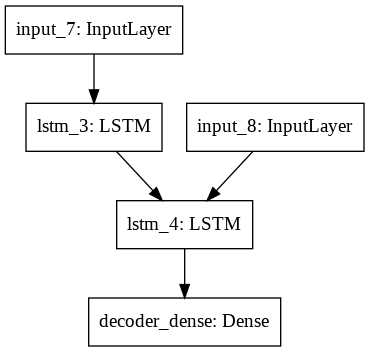

In [56]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')
from IPython.display import Image
Image(filename='model.png',height=400,width=400)

# The Model architecture is explined in the diagram above 

#### **Saving Model Architecture**

In [0]:
import json
# serialize model to JSON
model_json = model.to_json()
with open(DATA_SET_NAME+'/Industry Grade Project - Building a Chatbot/word-architecture.json', "w") as json_file:
    json_file.write(model_json)

# Check-5 

Check the model summary should look like this 

In [58]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, None, 100)    0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, None, 100)    0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 256), (None, 365568      input_7[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, None, 256),  365568      input_8[0][0]                    
                                                                 lstm_3[0][1]               

In [0]:
# Just Checking the size of the Training and testing set.
print('Length Xtrain :',len(Xtrain))
print('Length Xtest :',len(Xtest))
print('Length Ytrain :',len(Ytrain))
print('Length Ytest :',len(Ytest))

Length Xtrain : 243554
Length Xtest : 60889
Length Ytrain : 243554
Length Ytest : 60889


### Execution and updation of weights in Batches

In [0]:
test_gen = generate_batch(Xtest, Ytest)

In [0]:
train_num_batches = len(Xtrain) // BATCH_SIZE
test_num_batches = len(Xtest) // BATCH_SIZE

### Saving of MODEL at checks through checkpoint

In [0]:
checkpoint = ModelCheckpoint(filepath=WEIGHT_FILE_PATH, save_best_only=True)

# **MODEL TRAINING**

In [0]:
#fitting of chatbot model
history = model.fit_generator(generator=train_gen, steps_per_epoch=train_num_batches,
                    epochs=NUM_EPOCHS,
                    verbose=1, validation_data=test_gen, validation_steps=test_num_batches, callbacks=[checkpoint])

Epoch 1/10
7611/7611 [==============================] - 1744s 229ms/step - loss: 1.4090 - accuracy: 0.0840 - val_loss: 1.2544 - val_accuracy: 0.0907
Epoch 2/10
7611/7611 [==============================] - 1736s 228ms/step - loss: 1.3517 - accuracy: 0.0917 - val_loss: 1.2474 - val_accuracy: 0.0927
Epoch 3/10
7611/7611 [==============================] - 1725s 227ms/step - loss: 1.3618 - accuracy: 0.0928 - val_loss: 1.2573 - val_accuracy: 0.0929
Epoch 4/10
7611/7611 [==============================] - 1702s 224ms/step - loss: 1.3671 - accuracy: 0.0926 - val_loss: 1.2520 - val_accuracy: 0.0926
Epoch 5/10
7611/7611 [==============================] - 1701s 224ms/step - loss: 1.3810 - accuracy: 0.0923 - val_loss: 1.2676 - val_accuracy: 0.0926
Epoch 6/10
7611/7611 [==============================] - 1716s 225ms/step - loss: 1.3878 - accuracy: 0.0921 - val_loss: 1.2567 - val_accuracy: 0.0927
Epoch 7/10
7611/7611 [==============================] - 1723s 226ms/step - loss: 1.3817 - accuracy: 0.0928

### Final Weights saved at desired location

In [0]:
model.save_weights(WEIGHT_FILE_PATH)

**PLOT IT !**

* **Model Accuracy after 10 Epochs**

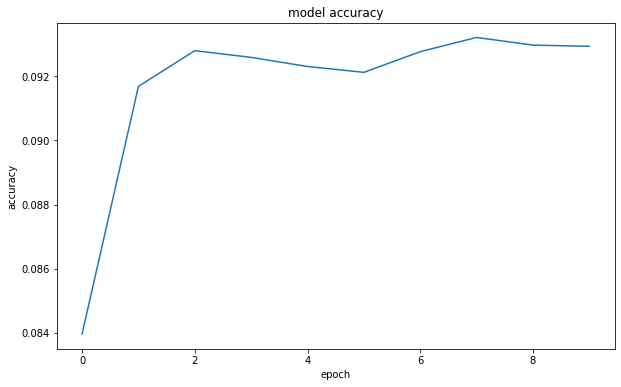

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

* **Model Loss after 10 Epochs**

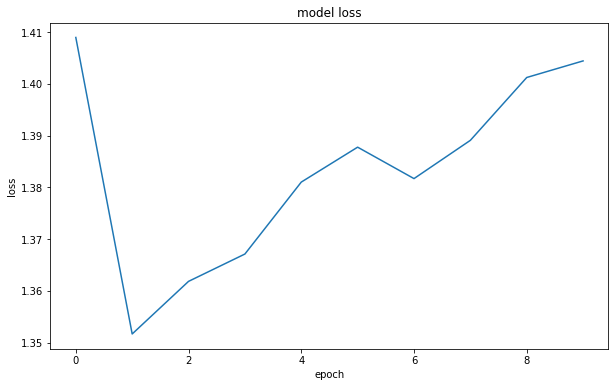

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

**LOAD MODEL** 

* Lets load the <font color='DARKBLUE'>**[ PRE-TRAINED ]**</font> *Model Weights* and *Model Architecture*.

In [0]:
from tensorflow.keras.models import model_from_json

In [80]:
filename = DATA_SET_NAME+'/Industry Grade Project - Building a Chatbot/model-weights.h5'

json_file = open(DATA_SET_NAME+'/Industry Grade Project - Building a Chatbot/word-architecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(filename)
print('Model Loaded !')

Model Loaded !


### Compile the model using the **rmsprop** optimizer and  **categorical_crossentropy** loss function.

In [0]:
loaded_model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop')

# Prediction

![Encoder-Decoder](https://qph.fs.quoracdn.net/main-qimg-7dab66200fb636d8eb882475e6a4fe87)

## Inference

In [0]:
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_inputs = [Input(shape=(HIDDEN_UNITS,)), Input(shape=(HIDDEN_UNITS,))]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_state_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs] + decoder_states)

## **STEPS:**


1.   Encode the Input Sequence,returns its **internal states**. { **states_value** }
2.   Run Decoder using start of sequence character as input and encoder's internal states as decoder initial states .{ **[target_seq] + states_value** } 
3.   **Append** the **character predicted** by the decoder **to decoded sequence** ie [ **target_text** ].
4.    **Repeat** the process with the previously predicted character token as input and updates internal states
  
```
                    ENCODE -> DECODE -> APPEND -> REPEAT
```





In [0]:
def reply(input_text):
        input_seq = []
        input_emb = []
        for word in nltk.word_tokenize(input_text.lower()):
            if not in_white_list(word):
                continue
            emb = np.zeros(shape=GLOVE_EMBEDDING_SIZE)
            if word in word2embedding:
                emb = word2embedding[word]
            
            input_emb.append(emb)
            #print('input_emb --',input_emb)
        input_seq.append(input_emb)
        #print('input_seq --',input_seq)
        input_seq = pad_sequences(input_seq,encoder_max_seq_length)
        states_value = encoder_model.predict(input_seq)
        #print('States Value --',states_value)
        target_seq = np.zeros((1, 1, GLOVE_EMBEDDING_SIZE))
        target_seq[0, 0, :] = word2embedding['start']
        #print('Target Sequence - ',target_seq)
        target_text = ''
        target_text_len = 0
        terminated = False
        while not terminated:
            output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
            #print('Output tokens -',output_tokens,'h -',h,'c -',c)
            sample_token_idx = np.argmax(output_tokens[0, -1, :])
            sample_word = target_idx2word[sample_token_idx]
            target_text_len += 1

            if sample_word != 'start' and sample_word != 'end':
                target_text += ' ' + sample_word

            if sample_word == 'end' or target_text_len >= decoder_max_seq_length:
                terminated = True

            target_seq = np.zeros((1, 1, GLOVE_EMBEDDING_SIZE))
            if sample_word in word2embedding:
                target_seq[0, 0, :] = word2embedding[sample_word]

            states_value = [h, c]
        return target_text.strip()

# Testing Model

In [0]:
def test_model(ques):
    rikisays=reply(ques)
    return rikisays

In [78]:
mayank= 'Are you free tommorow?'
print('Mayank :',mayank)
riki = test_model(mayank)
print('Riki :',riki)

Mayank : Are you free tommorow?
Riki : both madness madness madness madness laurie madness madness battlefield rifles offensive concerned rubbing hid offensive rubbing hid offensive rubbing hid tomb gag child concerned ross powerful majority businessman subscription pinned gag concerned past jordan jordan jordan james solve hid hid jordan jordan


## <font color='orange'> ............... **NEEDS MORE TRAINING**...............</font>



> **SUMMARY**



1.   Load the glove word embedding in to a dictionary where the **key** is a unique **word token** and the **value** is a **d** dimension vector 
2.   Basic Text Preprocessing 
3.   We are adding **start** and **end** to every target text.This will later help our **MODEL** to determine **when to start** and more importantly - **end sequences** . We need this due to the fact that we dont know a-priori how long the output sequence will be.
4. We are creating two dictioinary **target_idx2word** and **target_word2idx** .We are considerding only **100** most comman tokens with highest frequency.
5. But these input text won't work as input to our model.We **need to convert characters into numerical values**.For Embedding we i am using GLOVE.
6. We'll need input data for both the encoder and the decoder of the model, as well as the target data.<br>[**GENERATING INPUT DATA PER BATCH**]

*  The **encoder_input_data_batch** will consist of  samples of the maximum sequence length (40) filled with the respective one-hot-encoded tokens
*   The **decoder_input_data_batch** and the **decoder_target_data_batch ** are both constructed in the same way as the input data for the encoder.
*   We need to construct those two sequences because we're training our model through a process called teacher forcing, where the decoder learns to generate **decoder_target_data_batch[lineIdx, idx - 1, w2idx]** given **decoder_input_data_batch[lineIdx, idx, :]** while taking into account the input sequence via the encoder's internal state. Therefore we have to offset decoder_target_data_batch by one timestep.
7. Building the **MODEL**

*   Model consists of **2 LSTM'S**.
*   **1st LSTM** will be serve as **Encoder**,encoding the input sequences and producing the internal state vectors.
*   **2nd LSTM** is responsible for predicting (**Decoder**) the indivisual characters of the target sequence.
*  While creating the 1st LSTM layer,**return_state=True**.since we want to use the **ENCODER internal state vectors** for the DECODER.
* Using ENCODER internal state vectors to build DECODER
* While creating 2nd LSTM layer,**return_sequences=True, return_state=True**.We are **not using DECODER internal state vectors (Later,we will use this for INFERENCE)** for training.
* Use **DENSE Layer** for getting the indivisual character from the decoder's output.
* Now,glue both the part together using **Keras's MODEL functional API**
8. Compile the model using the  rmsprop optimizer and  categorical_crossentropy loss function.
9. Training the **MODEL** with given hyperparameters.
10. Testing the **MODEL**








 <font color='green'> **..............  THE END ................**</font>